# 1. Install Dependencies and Setup

In [ ]:
!git clone https://github.com/tripedro/ImageClassifier.git

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove questionable images

In [7]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [8]:
data_dir = '/content/ImageClassifier/data'

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
img = cv2.imread(os.path.join('ImageClassifier', 'data', 'raccoon', '0B4ED7B8-6C6A-4031-BEE1253D115FD0CC_source.jpg'))
img.shape # numpy shape

(2937, 4434, 3)

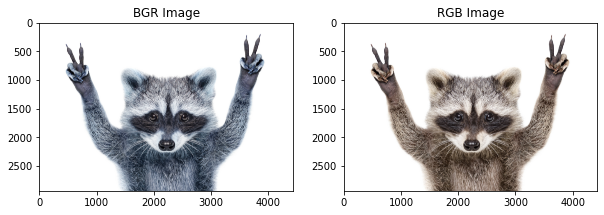

In [11]:
# Create a figure and set its size
fig = plt.figure(figsize=(10, 5))

# opencv reads it in BGR, matplotlib expects it to be rgb
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("BGR Image")
ax1.imshow(img)

# to fix, we just reorder the color channels
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("RGB Image")
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 

# Show the figure
plt.show()

In [12]:
# loop through data folders
for image_class in os.listdir(data_dir): 
    # loop through each img
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list /content/ImageClassifier/data/raccoon/4568321-min.jpg
Image not in ext list /content/ImageClassifier/data/raccoon/raccoons-536658.jpg
Image not in ext list /content/ImageClassifier/data/raccoon/Raccoon-Names-SN-long.jpg
Image not in ext list /content/ImageClassifier/data/raccoon/Raccoon_FredShelton.jpg.webp
Image not in ext list /content/ImageClassifier/data/raccoon/raccoon-North-American.jpg
Image not in ext list /content/ImageClassifier/data/raccoon/Raccoonzoopedia.jpg
Image not in ext list /content/ImageClassifier/data/raccoon/young-raccoon-standing-front-facing-600w-1928410055.jpg
Image not in ext list /content/ImageClassifier/data/raccoon/Raccoon-Cooper09.jpg
Image not in ext list /content/ImageClassifier/data/boston_terrier/Boston-Terrier-Illo-2.jpg
Image not in ext list /content/ImageClassifier/data/boston_terrier/Blue-Boston-Terrier-HP-long.jpg
Image not in ext list /content/ImageClassifier/data/boston_terrier/Boston-Terrier-dog.jpg
Image not in ext list /

# 3. Load Data

In [13]:
import numpy as np

In [28]:
""" PREPROCESSING
Creates batches at size of 32
resizes images to 256, 256, etc
"""
data = tf.keras.utils.image_dataset_from_directory('/content/ImageClassifier/data')

Found 224 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator() # pull consistant data

In [16]:
batch = data_iterator.next() # grab a batch
print(batch[0].shape) # imgs represented as numpy arrays
print(batch[1]) # labels: 1-racc 0-bt

(32, 256, 256, 3)
[0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 1]


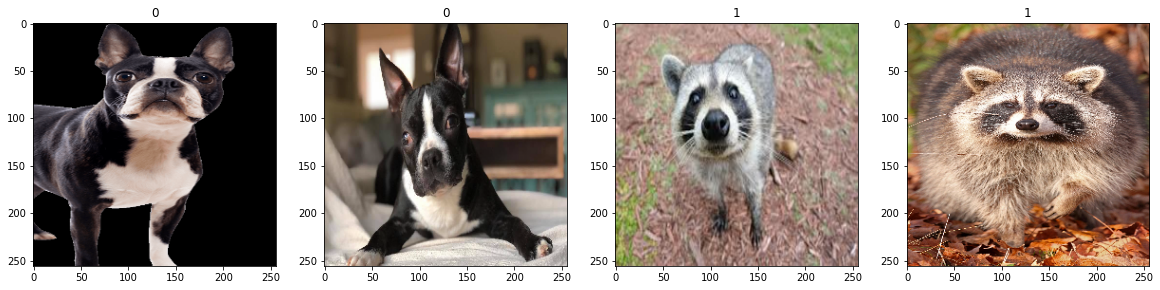

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [29]:
data = data.map(lambda x,y: (x/255, y)) # x: imgs y: labels

In [19]:
batch2 = data.as_numpy_iterator().next()

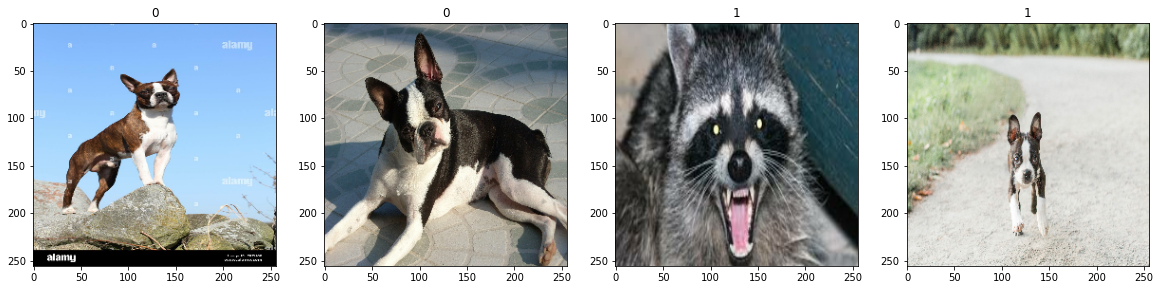

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch2[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [30]:
train_size = int(len(data)*.7) # 70%
val_size = int(len(data)*.2) # 20%
test_size = int(len(data)*.1) # 10%

print(train_size + val_size + test_size)

5


In [31]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

print(len(train))
print(len(val))
print(len(test))

4
1
0


# 6. Build Deep Learning Model

In [32]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [34]:
model = Sequential()

In [35]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [38]:
logdir='logs'

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 19s 1s/step - loss: 1.6411 - accuracy: 0.4844 - val_loss: 0.7502 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 7s 1s/step - loss: 0.6998 - accuracy: 0.5000 - val_loss: 0.6886 - val_accuracy: 0.7500
Epoch 3/20
4/4 [==============================] - 7s 1s/step - loss: 0.6891 - accuracy: 0.5703 - val_loss: 0.6819 - val_accuracy: 0.6250
Epoch 4/20
4/4 [==============================] - 8s 1s/step - loss: 0.6833 - accuracy: 0.5859 - val_loss: 0.6993 - val_accuracy: 0.3438
Epoch 5/20
4/4 [==============================] - 9s 2s/step - loss: 0.6750 - accuracy: 0.5625 - val_loss: 0.6602 - val_accuracy: 0.7188
Epoch 6/20
4/4 [==============================] - 7s 1s/step - loss: 0.6473 - accuracy: 0.7969 - val_loss: 0.6362 - val_accuracy: 0.8750
Epoch 7/20
4/4 [==============================] - 8s 1s/step - loss: 0.6131 - accuracy: 0.8047 - val_loss: 0.5661 - val_accuracy: 0.9688
Epoch 8/20
4/4 [========================

# Plot Performance

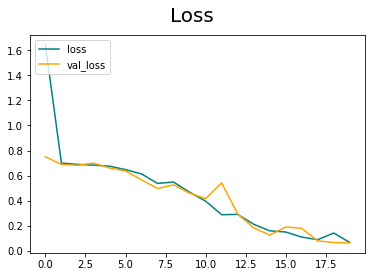

In [41]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

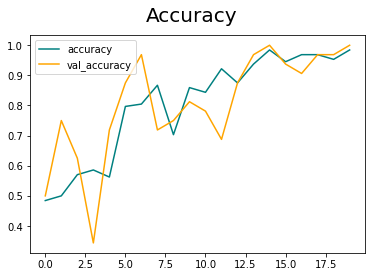

In [42]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [43]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [44]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [45]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [46]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# Test

In [ ]:
import cv2

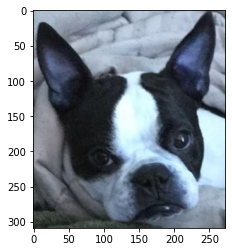

In [60]:
img = cv2.imread('/content/bert2.JPG')
plt.imshow(img)
plt.show()

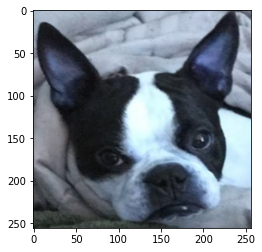

In [61]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [62]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 22ms/step


In [63]:
if yhat > 0.5: 
    print(f'Predicted class is Raccoon')
else:
    print(f'Predicted class is Boston Terrier')

Predicted class is Boston Terrier


# Save the Model

In [67]:
from tensorflow.keras.models import load_model

In [70]:
model.save(os.path.join('content','imageclassifier.h5'))

In [72]:
new_model = load_model('/content/models/imageclassifier.h5')

In [73]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 108ms/step


array([[0.40140283]], dtype=float32)